<a href="https://colab.research.google.com/github/raflinoob132/MachineLearning-1/blob/main/UTS/Task%20Clustering/UTS_Task_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, f_classif, mutual_info_classif
from scipy.cluster.hierarchy import dendrogram
import warnings
warnings.filterwarnings('ignore')
# Download dataset
import gdown
file_id = "1HIJVXKQwABrxDVoKj3eMTCmQ7T8LinF8"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output="UTSClustering.csv", quiet=False)




# Load dataset
df = pd.read_csv("UTSClustering.csv", encoding='ISO-8859-1')
df.head()

Downloading...
From: https://drive.google.com/uc?id=1HIJVXKQwABrxDVoKj3eMTCmQ7T8LinF8
To: /content/UTSClustering.csv
100%|██████████| 45.6M/45.6M [00:00<00:00, 73.8MB/s]


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [12]:
df.shape

(541909, 8)

In [17]:


# 1. Pengumpulan & Pembersihan Data
print("1. PENGUMPULAN DAN PEMBERSIHAN DATA")
print("="*50)

# Membaca dataset

print("Dataset awal:")
print(df.info())
print("\nJumlah data:", df.shape[0])
print("Jumlah fitur:", df.shape[1])

# Memeriksa missing values
print("\nJumlah missing values:")
print(df.isnull().sum())

# Pembersihan data
# Menghapus baris dengan Description yang kosong
df = df.dropna(subset=['Description'])

# Menangani CustomerID yang hilang
# CustomerID yang hilang akan diisi dengan nilai -1 (menandakan pelanggan tidak diketahui)
df['CustomerID'] = df['CustomerID'].fillna(-1)

# Konversi InvoiceDate menjadi tipe datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Menghapus transaksi dengan nilai negatif (pengembalian/return)
df = df[df['Quantity'] > 0]

# Menghitung TotalPrice sebagai Quantity * UnitPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Filter produk dengan harga 0 atau sangat kecil
df = df[df['UnitPrice'] > 0]

# Memeriksa hasil pembersihan data
print("\nDataset setelah pembersihan:")
print(df.info())
print("\nJumlah data setelah pembersihan:", df.shape[0])


1. PENGUMPULAN DAN PEMBERSIHAN DATA
Dataset awal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None

Jumlah data: 541909
Jumlah fitur: 8

Jumlah missing values:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Dataset setelah pembersihan:
<class 'pandas.core.frame.DataFrame'>
Index: 530104 entries, 0



2. FEATURE ENGINEERING DAN FEATURE SELECTION

RFM DataFrame setelah dibuat:
         CustomerID      Recency    Frequency      Monetary
count   4215.000000  4215.000000  4215.000000   4215.000000
mean   15295.732384    92.192883     3.627521   1344.726150
std     1719.777338    99.602120     3.753600   1881.394542
min    12347.000000     0.000000     1.000000     52.200000
25%    13813.500000    18.000000     1.000000    308.840000
50%    15292.000000    51.000000     2.000000    664.540000
75%    16774.500000   142.000000     4.000000   1592.090000
max    18287.000000   373.000000    25.000000  18895.910000

Feature Selection:
1. Menghapus fitur dengan varians rendah:
Jumlah fitur setelah penghapusan varians rendah: 3

2. Korelasi antar fitur:
           Recency  Frequency  Monetary
Recency    1.00000  -0.392290 -0.310530
Frequency -0.39229   1.000000  0.754005
Monetary  -0.31053   0.754005  1.000000


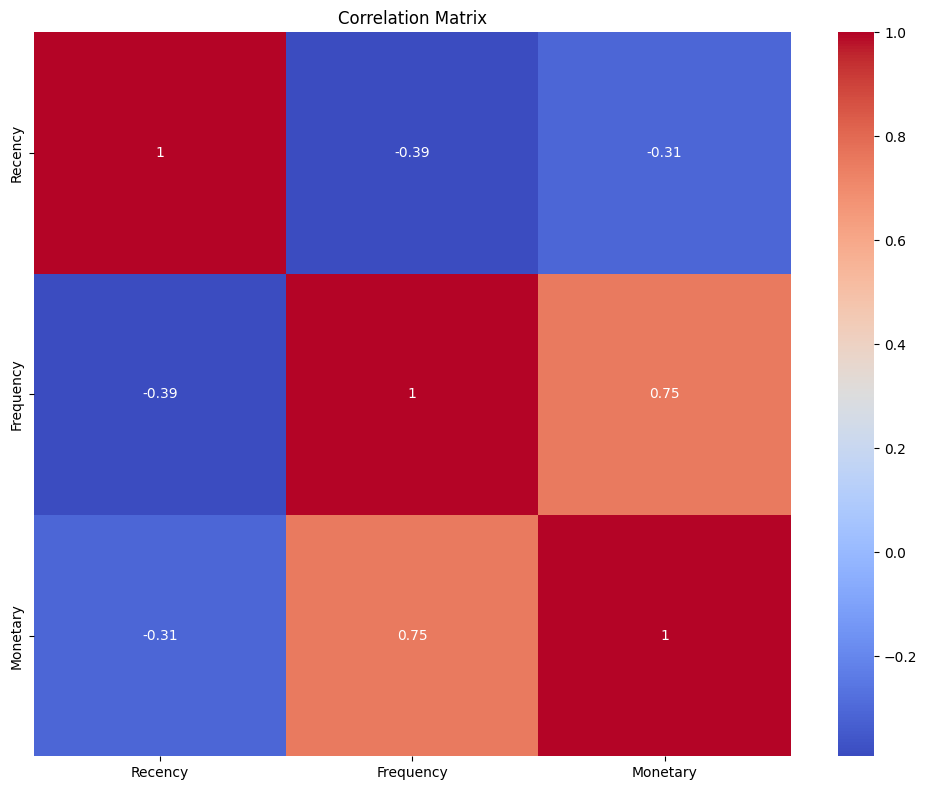


3. Standardisasi Data:
Data setelah standardisasi:
            Recency     Frequency      Monetary
count  4.215000e+03  4.215000e+03  4.215000e+03
mean   2.907915e-17 -7.164429e-18 -9.440188e-17
std    1.000119e+00  1.000119e+00  1.000119e+00
min   -9.257215e-01 -7.000833e-01 -6.870858e-01
25%   -7.449810e-01 -7.000833e-01 -5.506602e-01
50%   -4.136234e-01 -4.336407e-01 -3.615759e-01
75%    5.001201e-01  9.924431e-02  1.314946e-01
max    2.819623e+00  5.694537e+00  9.329923e+00


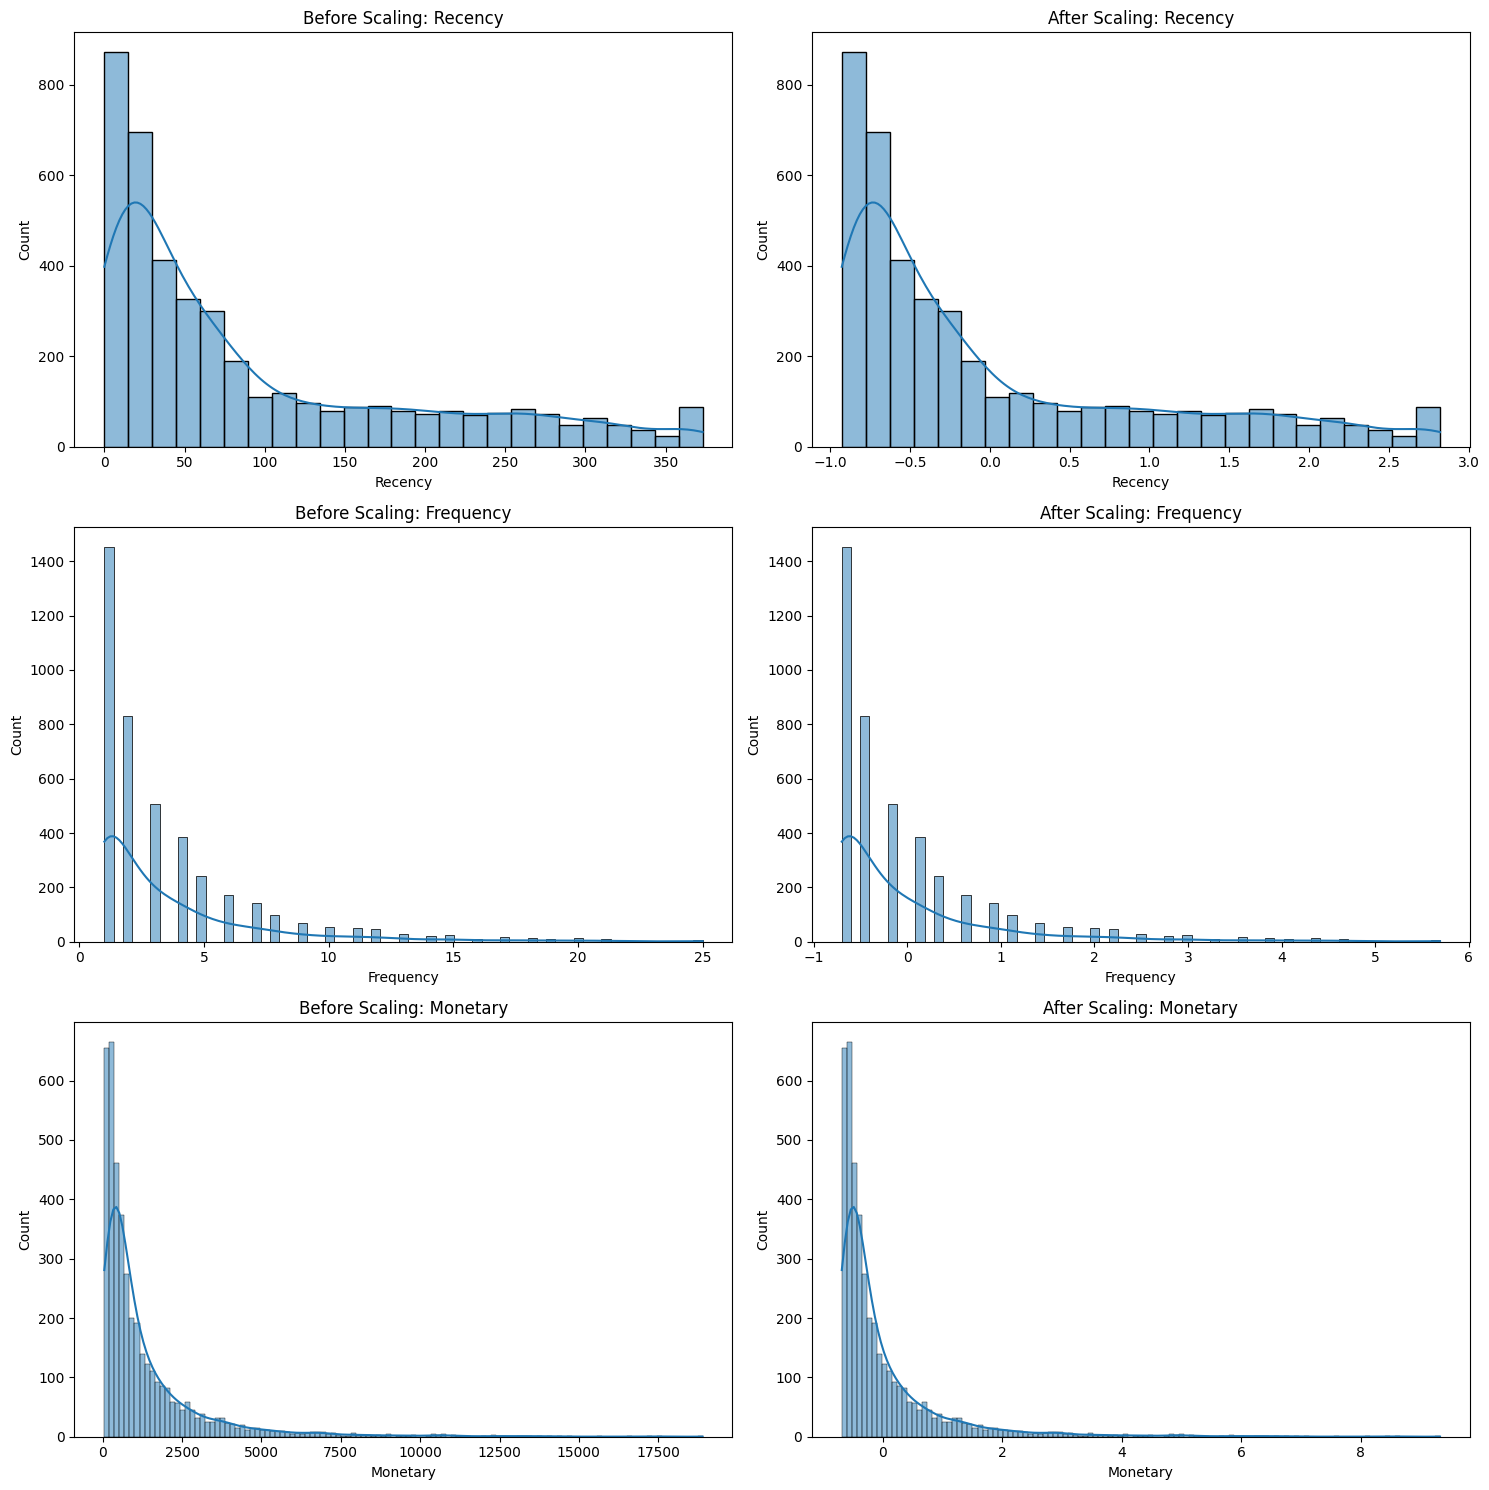

In [18]:

# 2. Feature Engineering dan Feature Selection
print("\n\n2. FEATURE ENGINEERING DAN FEATURE SELECTION")
print("="*50)

# Transformasi data - Mendapatkan tanggal dan waktu
df['Day'] = df['InvoiceDate'].dt.day
df['Month'] = df['InvoiceDate'].dt.month
df['Year'] = df['InvoiceDate'].dt.year
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# Feature Engineering: RFM Analysis (Recency, Frequency, Monetary)
# Menentukan tanggal akhir sebagai tanggal maksimum dalam dataset
max_date = df['InvoiceDate'].max()

# Mengelompokkan berdasarkan CustomerID
rfm_df = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (max_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                             # Frequency
    'TotalPrice': 'sum'                                 # Monetary
})

# Mengubah nama kolom
rfm_df.columns = ['Recency', 'Frequency', 'Monetary']

# Menambahkan CustomerID sebagai indeks
rfm_df = rfm_df.reset_index()

# Menghapus nilai outlier (yang sangat ekstrim)
q_low_monetary = rfm_df['Monetary'].quantile(0.01)
q_high_monetary = rfm_df['Monetary'].quantile(0.99)
rfm_df = rfm_df[(rfm_df['Monetary'] >= q_low_monetary) & (rfm_df['Monetary'] <= q_high_monetary)]

q_high_freq = rfm_df['Frequency'].quantile(0.99)
rfm_df = rfm_df[rfm_df['Frequency'] <= q_high_freq]

print("\nRFM DataFrame setelah dibuat:")
print(rfm_df.describe())

# Feature Selection
print("\nFeature Selection:")

# 1. Variance Threshold - Menghapus fitur dengan varians rendah
print("1. Menghapus fitur dengan varians rendah:")
selector = VarianceThreshold(threshold=0.01)
X_var = selector.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])
print(f"Jumlah fitur setelah penghapusan varians rendah: {X_var.shape[1]}")

# 2. Korelasi antar fitur
print("\n2. Korelasi antar fitur:")
corr_matrix = rfm_df[['Recency', 'Frequency', 'Monetary']].corr()
print(corr_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# 3. Feature Scaling/Normalization
print("\n3. Standardisasi Data:")
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])
print("Data setelah standardisasi:")
print(rfm_scaled_df.describe())

# Visualisasi distribusi sebelum dan sesudah standarisasi
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
features = ['Recency', 'Frequency', 'Monetary']

for i, feature in enumerate(features):
    sns.histplot(rfm_df[feature], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Before Scaling: {feature}')

    sns.histplot(rfm_scaled_df[feature], kde=True, ax=axes[i, 1])
    axes[i, 1].set_title(f'After Scaling: {feature}')

plt.tight_layout()
plt.show()




3. IMPLEMENTASI MODEL CLUSTERING

1. K-Means Clustering
------------------------------


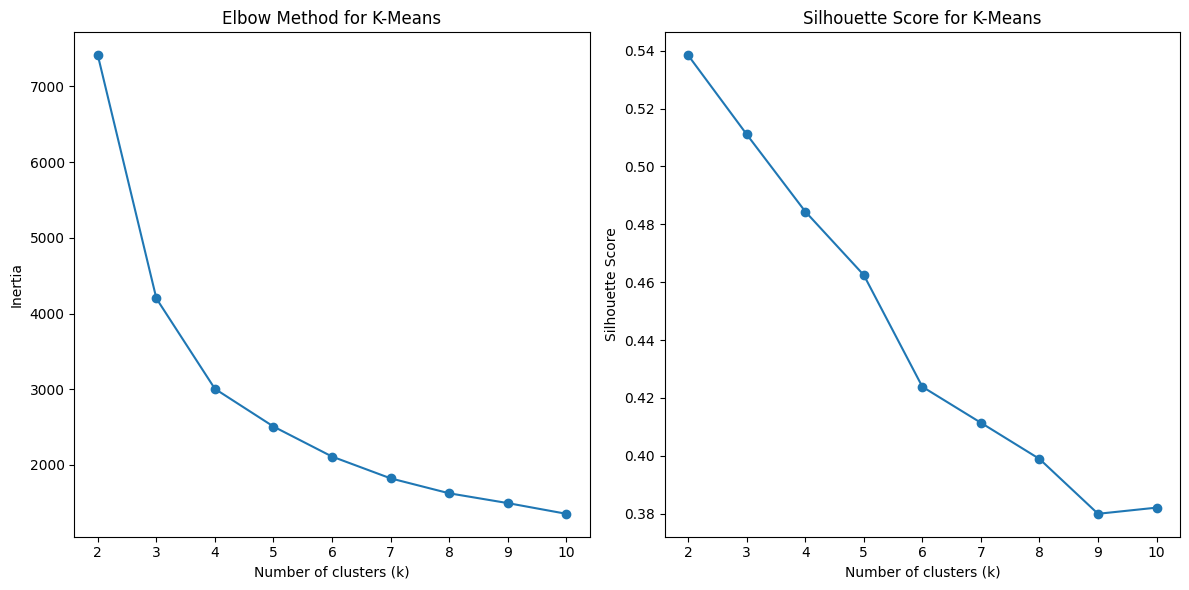

K-Means (k=5) Metrics:
Silhouette Score: 0.462
Davies-Bouldin Index: 0.843
Calinski-Harabasz Score: 4256.340


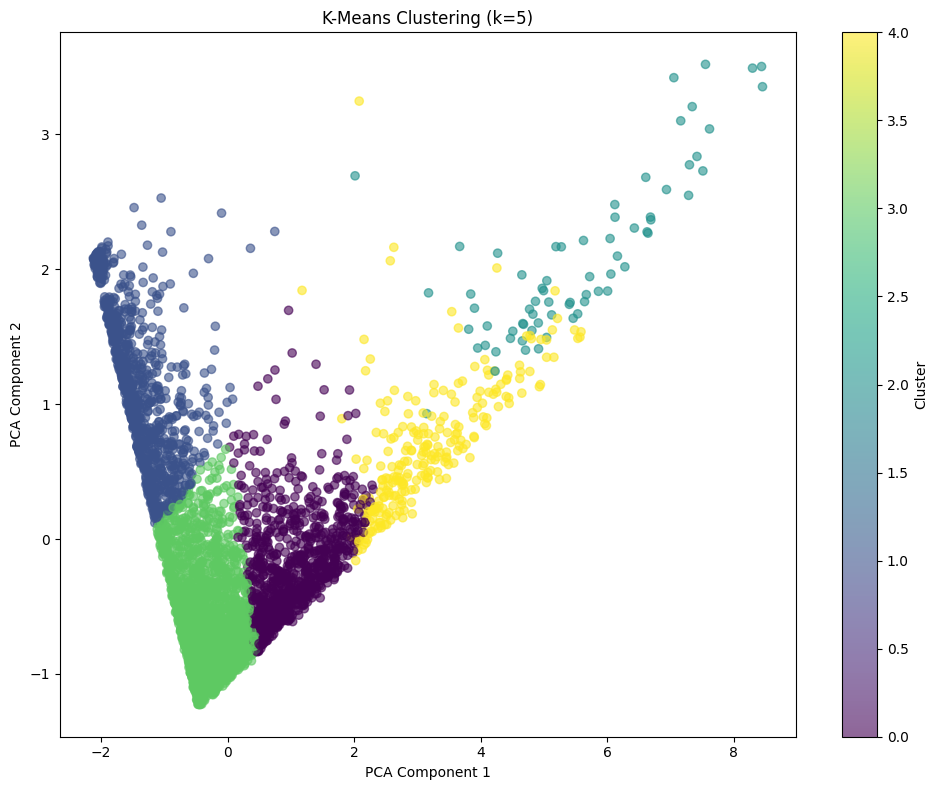

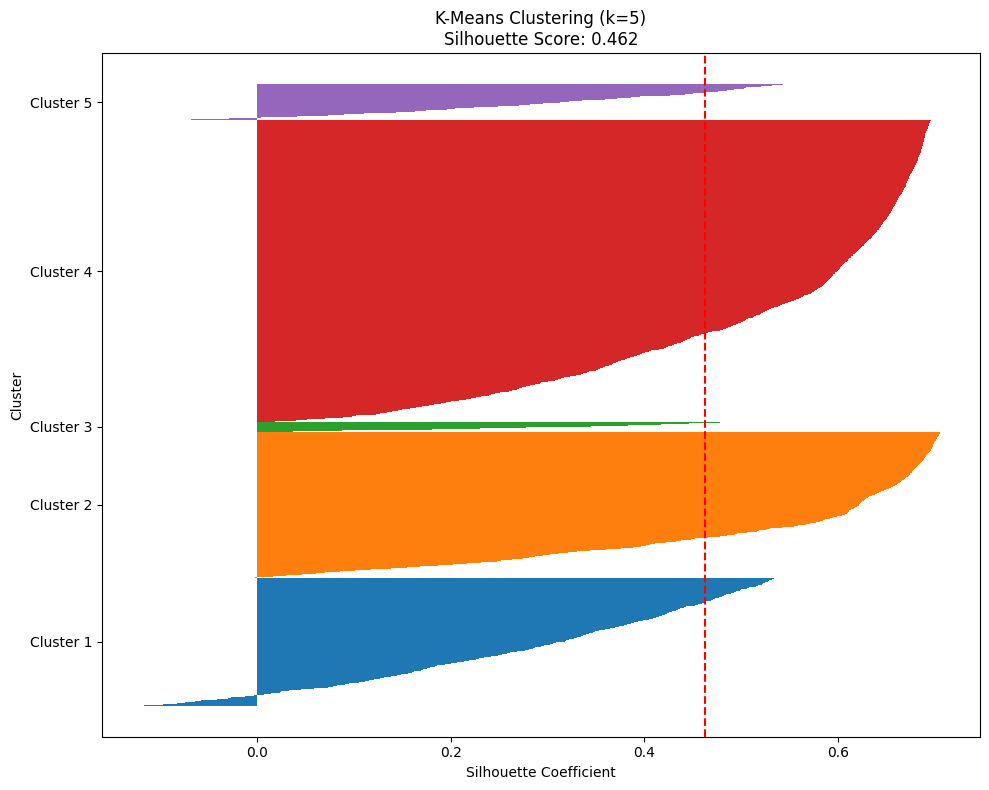


2. Agglomerative Clustering
------------------------------


<Figure size 1200x800 with 0 Axes>

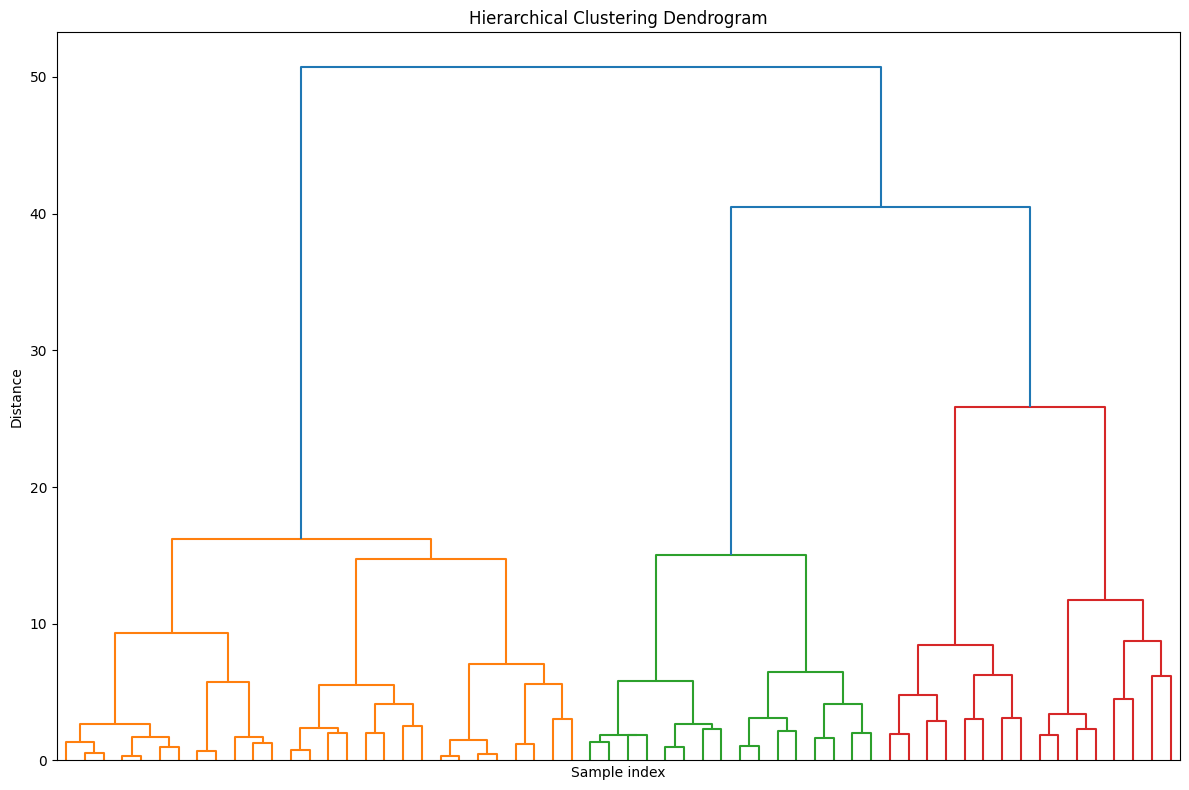

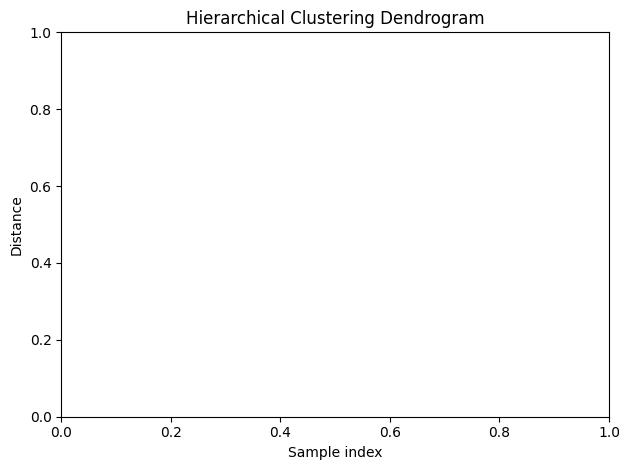

Agglomerative Clustering (k=5) Metrics:
Silhouette Score: 0.351
Davies-Bouldin Index: 0.966
Calinski-Harabasz Score: 3642.655


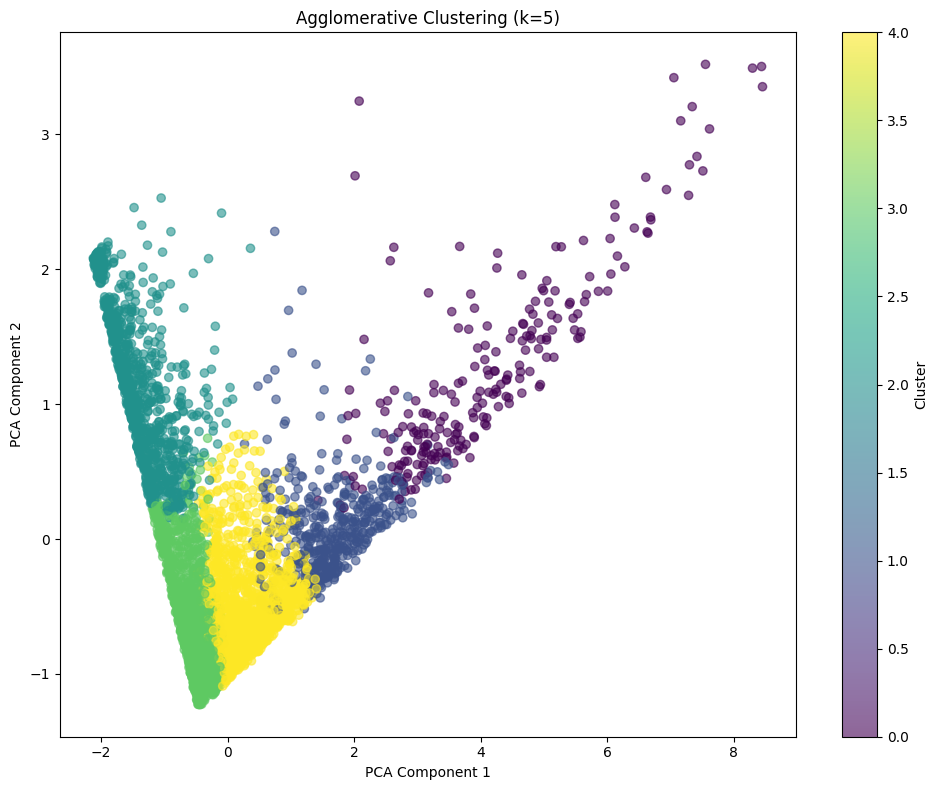

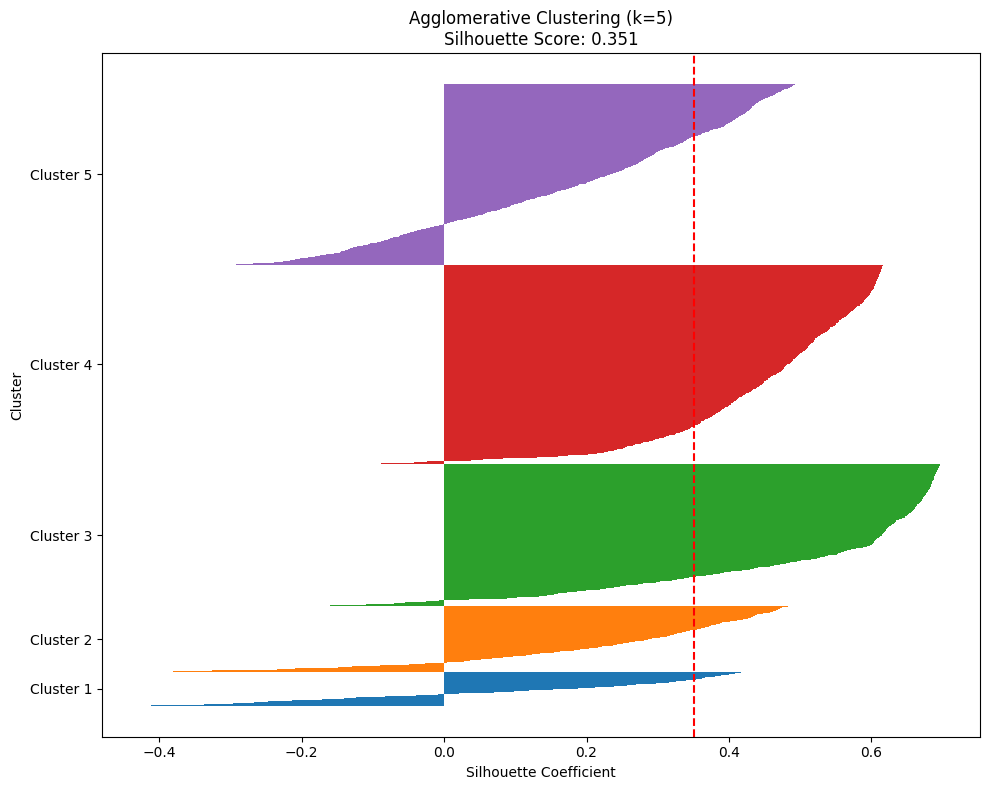


3. DBSCAN Clustering
------------------------------


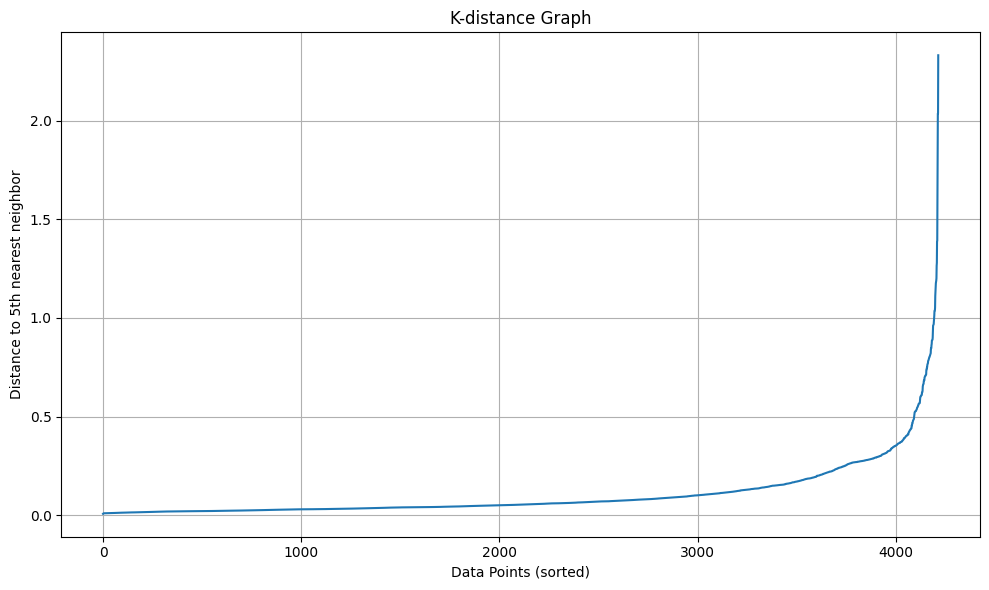

DBSCAN (eps=0.5, min_samples=5) Results:
Number of clusters: 1
Number of noise points: 83 (1.97%)
DBSCAN: Not enough clusters for evaluation metrics

4. Gaussian Mixture Model
------------------------------


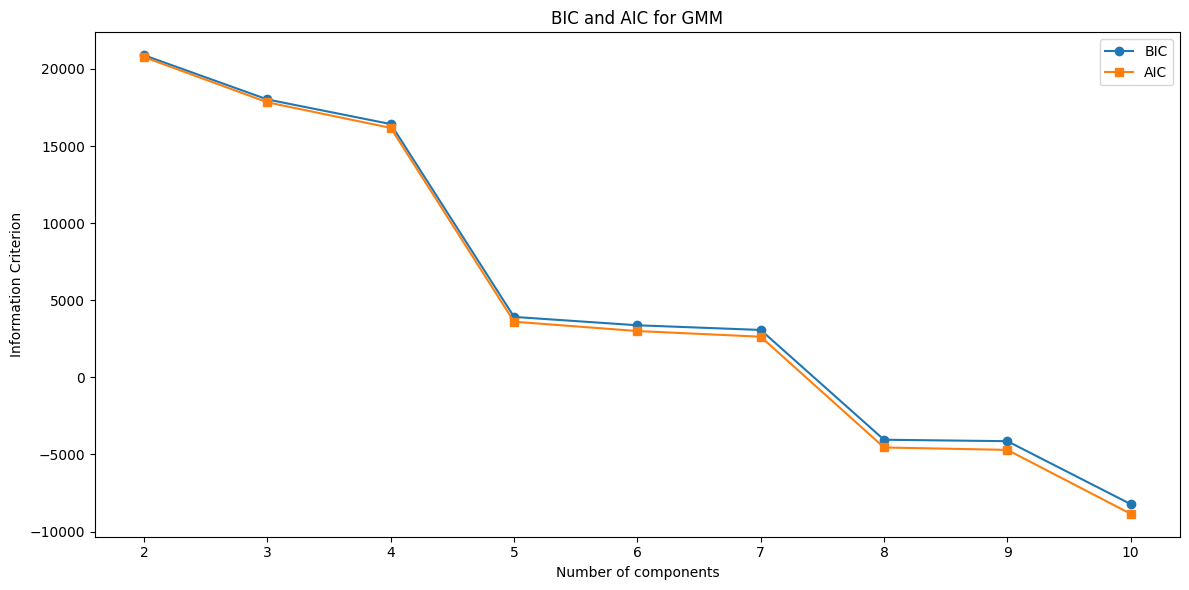

GMM (components=5) Metrics:
Silhouette Score: 0.086
Davies-Bouldin Index: 1.741
Calinski-Harabasz Score: 1460.288


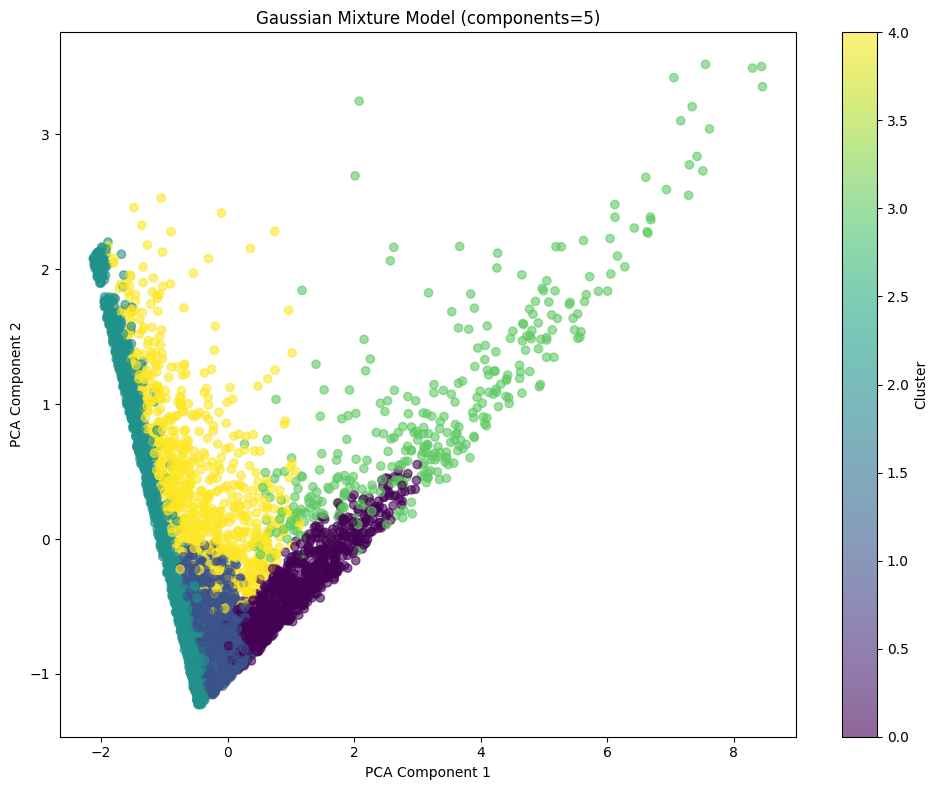

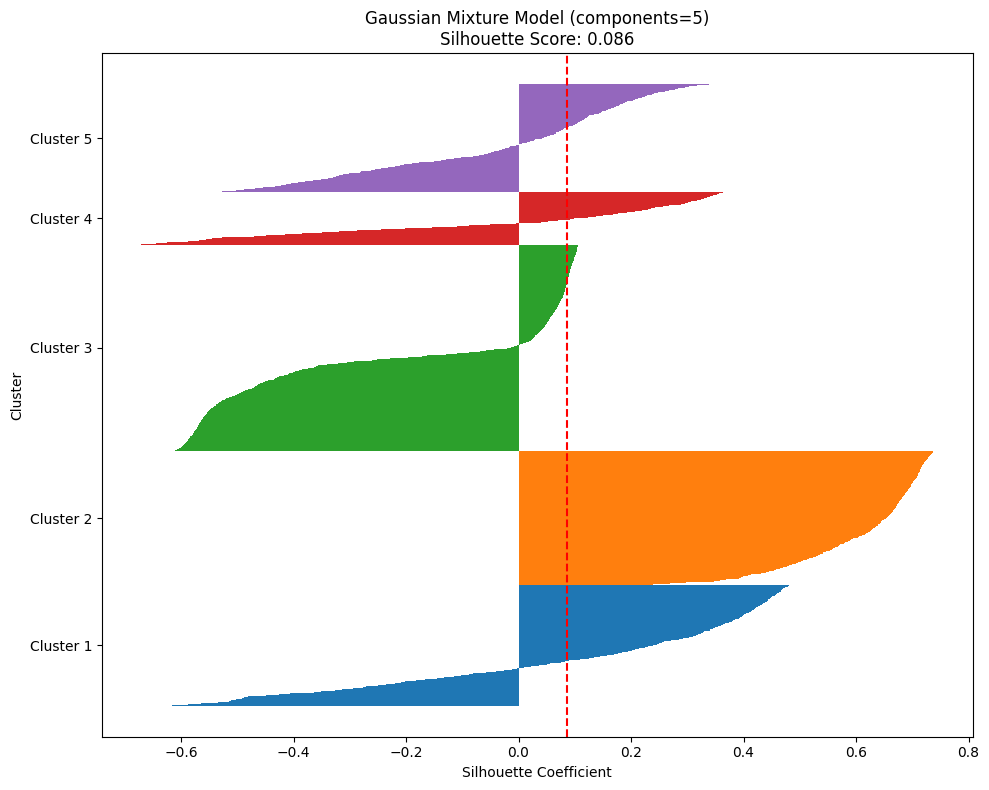


5. Spectral Clustering
------------------------------
Spectral Clustering (k=5) Metrics:
Silhouette Score: 0.119
Davies-Bouldin Index: 1.690
Calinski-Harabasz Score: 1222.372


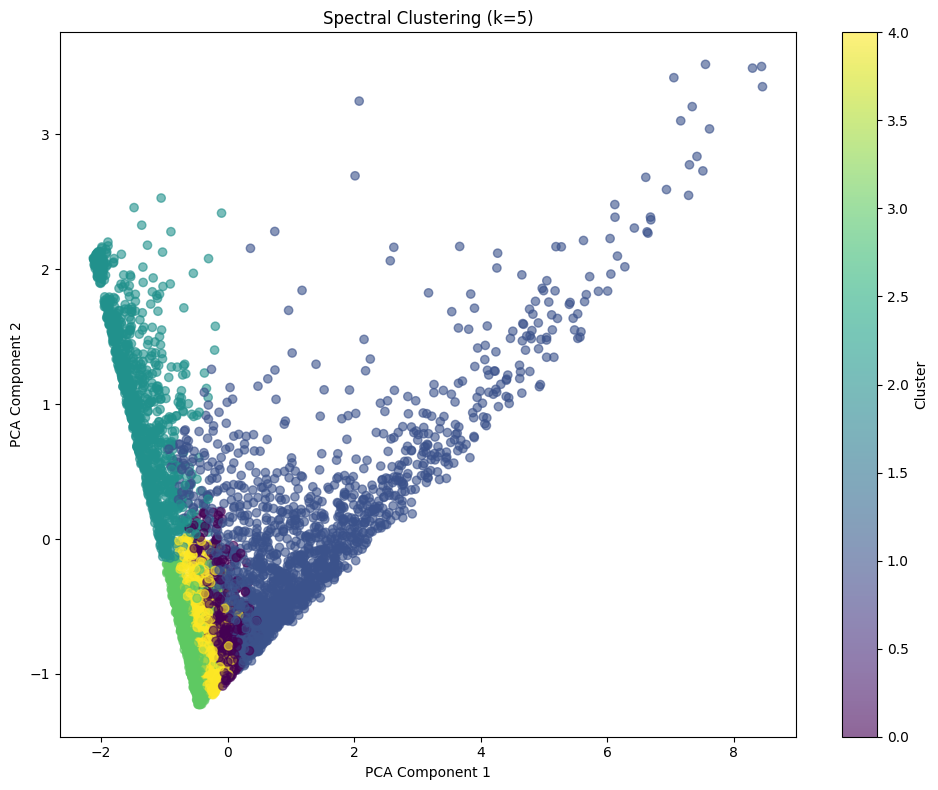

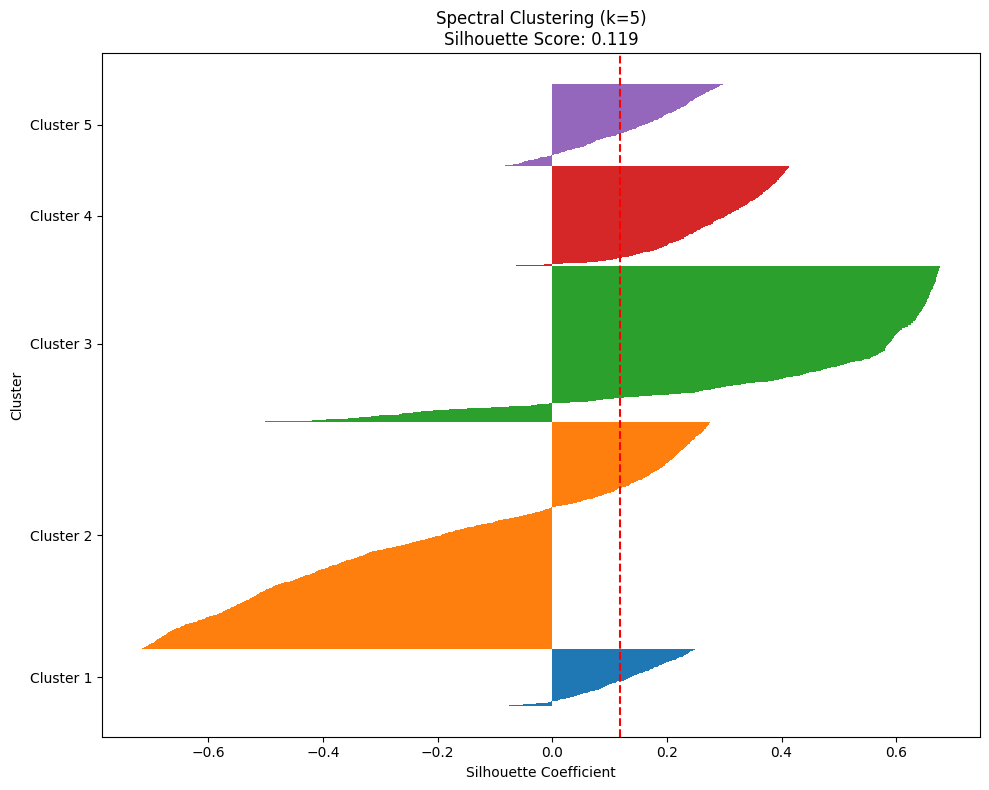

In [26]:

# 3. Clustering Models and Evaluation
print("\n\n3. IMPLEMENTASI MODEL CLUSTERING")
print("="*50)

# Menentukan matriks input untuk clustering
X = rfm_scaled

# Menyimpan hasil evaluasi
results = []

# Untuk visualisasi hasil clustering
def plot_clusters(X, labels, title):
    # Visualisasi dengan PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Cluster')
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.tight_layout()
    plt.show()

# Untuk visualisasi silhouette plot
def plot_silhouette(X, labels, title):
    from sklearn.metrics import silhouette_samples

    n_clusters = len(np.unique(labels))
    if n_clusters <= 1 or n_clusters >= len(X):
        return  # Tidak bisa membuat silhouette plot

    silhouette_vals = silhouette_samples(X, labels)

    plt.figure(figsize=(10, 8))
    y_ticks = []
    y_lower, y_upper = 0, 0

    for i in range(n_clusters):
        cluster_silhouette_vals = silhouette_vals[labels == i]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)

        plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, height=1.0)

        y_ticks.append((y_lower + y_upper) / 2)
        y_lower += len(cluster_silhouette_vals)

    silhouette_avg = silhouette_score(X, labels)
    plt.axvline(silhouette_avg, color='red', linestyle='--')
    plt.title(f'{title}\nSilhouette Score: {silhouette_avg:.3f}')
    plt.yticks(y_ticks, [f'Cluster {i+1}' for i in range(n_clusters)])
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette Coefficient')
    plt.tight_layout()
    plt.show()

    return silhouette_avg

# Untuk visualisasi dendrogram (khusus AgglomerativeClustering)
def plot_dendrogram(model, **kwargs):
    from scipy.cluster.hierarchy import dendrogram

    # Membuat dendrogram menggunakan sampel data jika data terlalu besar
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    plt.figure(figsize=(12, 8))
    dendrogram(linkage_matrix, **kwargs)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample index')
    plt.ylabel('Distance')
    plt.xticks([])  # Menghilangkan label sumbu x untuk kejelasan
    plt.tight_layout()
    plt.show()

# 1. K-Means Clustering
print("\n1. K-Means Clustering")
print("-" * 30)

# Menentukan jumlah cluster optimal dengan Elbow Method
inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

    # Menyimpan silhouette score
    if k > 1:  # Silhouette hanya valid untuk k > 1
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Plot Elbow Method
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for K-Means')

silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)

    # Menyimpan silhouette score
    if k > 1:  # Silhouette hanya valid untuk k > 1
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(list(k_range), silhouette_scores, 'o-')  # Cocokkan dengan jumlah nilai
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for K-Means')
plt.tight_layout()
plt.show()

# Memilih jumlah cluster optimal berdasarkan elbow dan silhouette
optimal_k = 5  # Biasanya diambil dari elbow point

# Menerapkan K-Means dengan jumlah cluster optimal
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X)

# Evaluasi K-Means
kmeans_silhouette = silhouette_score(X, kmeans_labels)
kmeans_db = davies_bouldin_score(X, kmeans_labels)
kmeans_ch = calinski_harabasz_score(X, kmeans_labels)

print(f"K-Means (k={optimal_k}) Metrics:")
print(f"Silhouette Score: {kmeans_silhouette:.3f}")
print(f"Davies-Bouldin Index: {kmeans_db:.3f}")
print(f"Calinski-Harabasz Score: {kmeans_ch:.3f}")

# Visualisasi hasil K-Means
plot_clusters(X, kmeans_labels, f'K-Means Clustering (k={optimal_k})')
plot_silhouette(X, kmeans_labels, f'K-Means Clustering (k={optimal_k})')

# Menambahkan hasil ke tabel perbandingan
results.append({
    'Model': f'K-Means (k={optimal_k})',
    'Silhouette Score': kmeans_silhouette,
    'Davies-Bouldin Index': kmeans_db,
    'Calinski-Harabasz Score': kmeans_ch
})

# 2. Agglomerative Clustering
print("\n2. Agglomerative Clustering")
print("-" * 30)

# Menerapkan Agglomerative Clustering dengan distance threshold
from sklearn.cluster import AgglomerativeClustering

# Membuat model dengan distance threshold dan jarak linkage
agg_model_for_dendrogram = AgglomerativeClustering(
    distance_threshold=0,
    n_clusters=None,
    linkage='ward',
    compute_distances=True
)
agg_model_for_dendrogram.fit(X[:1000])  # Menggunakan sampel untuk dendrogram

# Plot dendrogram
plt.figure(figsize=(12, 8))
plot_dendrogram(agg_model_for_dendrogram, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

# Menerapkan Agglomerative Clustering dengan jumlah cluster sama dengan K-Means
agg = AgglomerativeClustering(n_clusters=optimal_k)
agg_labels = agg.fit_predict(X)

# Evaluasi Agglomerative Clustering
agg_silhouette = silhouette_score(X, agg_labels)
agg_db = davies_bouldin_score(X, agg_labels)
agg_ch = calinski_harabasz_score(X, agg_labels)

print(f"Agglomerative Clustering (k={optimal_k}) Metrics:")
print(f"Silhouette Score: {agg_silhouette:.3f}")
print(f"Davies-Bouldin Index: {agg_db:.3f}")
print(f"Calinski-Harabasz Score: {agg_ch:.3f}")

# Visualisasi hasil Agglomerative Clustering
plot_clusters(X, agg_labels, f'Agglomerative Clustering (k={optimal_k})')
plot_silhouette(X, agg_labels, f'Agglomerative Clustering (k={optimal_k})')

# Menambahkan hasil ke tabel perbandingan
results.append({
    'Model': f'Agglomerative (k={optimal_k})',
    'Silhouette Score': agg_silhouette,
    'Davies-Bouldin Index': agg_db,
    'Calinski-Harabasz Score': agg_ch
})

# 3. DBSCAN
print("\n3. DBSCAN Clustering")
print("-" * 30)

from sklearn.neighbors import NearestNeighbors

# Menentukan epsilon (jarak) optimal dengan K-distance graph
n_neighbors = 5
neigh = NearestNeighbors(n_neighbors=n_neighbors)
neigh.fit(X)
distances, indices = neigh.kneighbors(X)

# Mengurutkan jarak untuk plot
distances = np.sort(distances[:, n_neighbors-1])

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-distance Graph')
plt.xlabel('Data Points (sorted)')
plt.ylabel(f'Distance to {n_neighbors}th nearest neighbor')
plt.grid(True)
plt.tight_layout()
plt.show()

# Berdasarkan k-distance graph, tentukan epsilon
eps = 0.5  # Nilai ini harus ditentukan dari grafik (biasanya di titik siku)
min_samples = 5

# Menerapkan DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X)

# Menghitung jumlah cluster dan noise points
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"DBSCAN (eps={eps}, min_samples={min_samples}) Results:")
print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise} ({n_noise/len(dbscan_labels)*100:.2f}%)")

# Evaluasi DBSCAN jika jumlah cluster > 1
dbscan_silhouette, dbscan_db, dbscan_ch = None, None, None

if n_clusters > 1:
    # Filter out noise points for evaluation
    X_filtered = X[dbscan_labels != -1]
    labels_filtered = dbscan_labels[dbscan_labels != -1]

    if len(np.unique(labels_filtered)) > 1:
        dbscan_silhouette = silhouette_score(X_filtered, labels_filtered)
        dbscan_db = davies_bouldin_score(X_filtered, labels_filtered)
        dbscan_ch = calinski_harabasz_score(X_filtered, labels_filtered)

        print(f"DBSCAN Metrics (excluding noise):")
        print(f"Silhouette Score: {dbscan_silhouette:.3f}")
        print(f"Davies-Bouldin Index: {dbscan_db:.3f}")
        print(f"Calinski-Harabasz Score: {dbscan_ch:.3f}")

        # Visualisasi hasil DBSCAN
        plot_clusters(X, dbscan_labels, f'DBSCAN (eps={eps}, min_samples={min_samples})')
        plot_silhouette(X_filtered, labels_filtered, f'DBSCAN (excluding noise)')
    else:
        print("DBSCAN: Not enough clusters for evaluation metrics")
else:
    print("DBSCAN: Not enough clusters for evaluation metrics")

# Menambahkan hasil DBSCAN ke tabel perbandingan jika memungkinkan
if dbscan_silhouette is not None:
    results.append({
        'Model': f'DBSCAN (eps={eps}, min_samples={min_samples})',
        'Silhouette Score': dbscan_silhouette,
        'Davies-Bouldin Index': dbscan_db,
        'Calinski-Harabasz Score': dbscan_ch
    })

# 4. Gaussian Mixture Model
print("\n4. Gaussian Mixture Model")
print("-" * 30)

# Menentukan jumlah komponen optimal dengan BIC
n_components_range = range(2, 11)
bic = []
aic = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X)
    bic.append(gmm.bic(X))
    aic.append(gmm.aic(X))

# Plot BIC/AIC
plt.figure(figsize=(12, 6))
plt.plot(n_components_range, bic, 'o-', label='BIC')
plt.plot(n_components_range, aic, 's-', label='AIC')
plt.xlabel('Number of components')
plt.ylabel('Information Criterion')
plt.title('BIC and AIC for GMM')
plt.legend()
plt.tight_layout()
plt.show()

# Pilih jumlah komponen berdasarkan BIC
optimal_components = 5  # Pilih berdasarkan grafik BIC

# Menerapkan Gaussian Mixture Model
gmm = GaussianMixture(n_components=optimal_components, random_state=42)
gmm_labels = gmm.fit_predict(X)

# Evaluasi GMM
gmm_silhouette = silhouette_score(X, gmm_labels)
gmm_db = davies_bouldin_score(X, gmm_labels)
gmm_ch = calinski_harabasz_score(X, gmm_labels)

print(f"GMM (components={optimal_components}) Metrics:")
print(f"Silhouette Score: {gmm_silhouette:.3f}")
print(f"Davies-Bouldin Index: {gmm_db:.3f}")
print(f"Calinski-Harabasz Score: {gmm_ch:.3f}")

# Visualisasi hasil GMM
plot_clusters(X, gmm_labels, f'Gaussian Mixture Model (components={optimal_components})')
plot_silhouette(X, gmm_labels, f'Gaussian Mixture Model (components={optimal_components})')

# Menambahkan hasil ke tabel perbandingan
results.append({
    'Model': f'GMM (components={optimal_components})',
    'Silhouette Score': gmm_silhouette,
    'Davies-Bouldin Index': gmm_db,
    'Calinski-Harabasz Score': gmm_ch
})

# 5. Spectral Clustering
print("\n5. Spectral Clustering")
print("-" * 30)

# Menerapkan Spectral Clustering
spectral = SpectralClustering(n_clusters=optimal_k, random_state=42, affinity='nearest_neighbors')
spectral_labels = spectral.fit_predict(X)

# Evaluasi Spectral Clustering
spectral_silhouette = silhouette_score(X, spectral_labels)
spectral_db = davies_bouldin_score(X, spectral_labels)
spectral_ch = calinski_harabasz_score(X, spectral_labels)

print(f"Spectral Clustering (k={optimal_k}) Metrics:")
print(f"Silhouette Score: {spectral_silhouette:.3f}")
print(f"Davies-Bouldin Index: {spectral_db:.3f}")
print(f"Calinski-Harabasz Score: {spectral_ch:.3f}")

# Visualisasi hasil Spectral Clustering
plot_clusters(X, spectral_labels, f'Spectral Clustering (k={optimal_k})')
plot_silhouette(X, spectral_labels, f'Spectral Clustering (k={optimal_k})')

# Menambahkan hasil ke tabel perbandingan
results.append({
    'Model': f'Spectral (k={optimal_k})',
    'Silhouette Score': spectral_silhouette,
    'Davies-Bouldin Index': spectral_db,
    'Calinski-Harabasz Score': spectral_ch
})




4. PERBANDINGAN DAN ANALISIS MODEL

Perbandingan Metrik Evaluasi:
                 Model  Silhouette Score  Davies-Bouldin Index  \
0        K-Means (k=5)          0.462457              0.843165   
1  Agglomerative (k=5)          0.350541              0.966258   
2   GMM (components=5)          0.085858              1.741200   
3       Spectral (k=5)          0.118727              1.690397   

   Calinski-Harabasz Score  
0              4256.340204  
1              3642.655101  
2              1460.288131  
3              1222.371779  


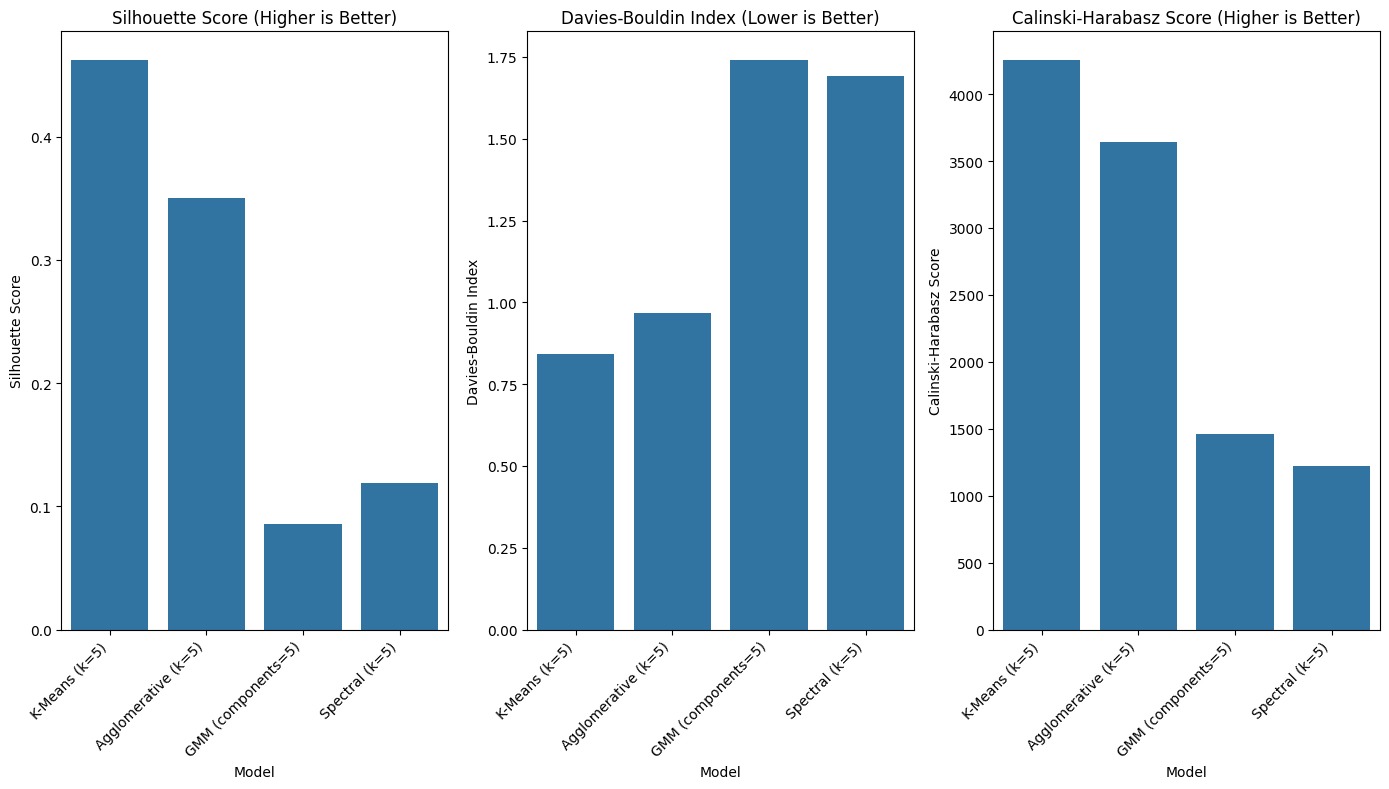


Model Terbaik berdasarkan Metrik:
Silhouette Score (Higher is Better): K-Means (k=5)
Davies-Bouldin Index (Lower is Better): K-Means (k=5)
Calinski-Harabasz Score (Higher is Better): K-Means (k=5)


In [27]:

# 4. Perbandingan dan Analisis Model
print("\n\n4. PERBANDINGAN DAN ANALISIS MODEL")
print("="*50)

# Membuat DataFrame hasil perbandingan
results_df = pd.DataFrame(results)
print("\nPerbandingan Metrik Evaluasi:")
print(results_df)

# Visualisasi perbandingan model
plt.figure(figsize=(14, 8))

# Plot Silhouette Score (higher is better)
plt.subplot(1, 3, 1)
sns.barplot(x='Model', y='Silhouette Score', data=results_df)
plt.title('Silhouette Score (Higher is Better)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Plot Davies-Bouldin Index (lower is better)
plt.subplot(1, 3, 2)
sns.barplot(x='Model', y='Davies-Bouldin Index', data=results_df)
plt.title('Davies-Bouldin Index (Lower is Better)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Plot Calinski-Harabasz Score (higher is better)
plt.subplot(1, 3, 3)
sns.barplot(x='Model', y='Calinski-Harabasz Score', data=results_df)
plt.title('Calinski-Harabasz Score (Higher is Better)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.tight_layout()
plt.show()

# Menentukan model terbaik berdasarkan metrik evaluasi
best_silhouette_model = results_df.loc[results_df['Silhouette Score'].idxmax()]['Model']
best_db_model = results_df.loc[results_df['Davies-Bouldin Index'].idxmin()]['Model']
best_ch_model = results_df.loc[results_df['Calinski-Harabasz Score'].idxmax()]['Model']

print("\nModel Terbaik berdasarkan Metrik:")
print(f"Silhouette Score (Higher is Better): {best_silhouette_model}")
print(f"Davies-Bouldin Index (Lower is Better): {best_db_model}")
print(f"Calinski-Harabasz Score (Higher is Better): {best_ch_model}")




5. INTERPRETASI HASIL DAN PROFILING CLUSTER

Analisis Cluster dari Model: K-Means (k=5)

Karakteristik setiap cluster:
            Recency  Frequency      Monetary  Count
Cluster                                            
0         30.923875   6.017301   2325.645467    867
1        251.987854   1.490891    443.471671    988
2         17.304348  15.043478  11137.639130     69
3         52.249267   2.092864    621.217416   2046
4         19.273469  13.387755   4791.951673    245


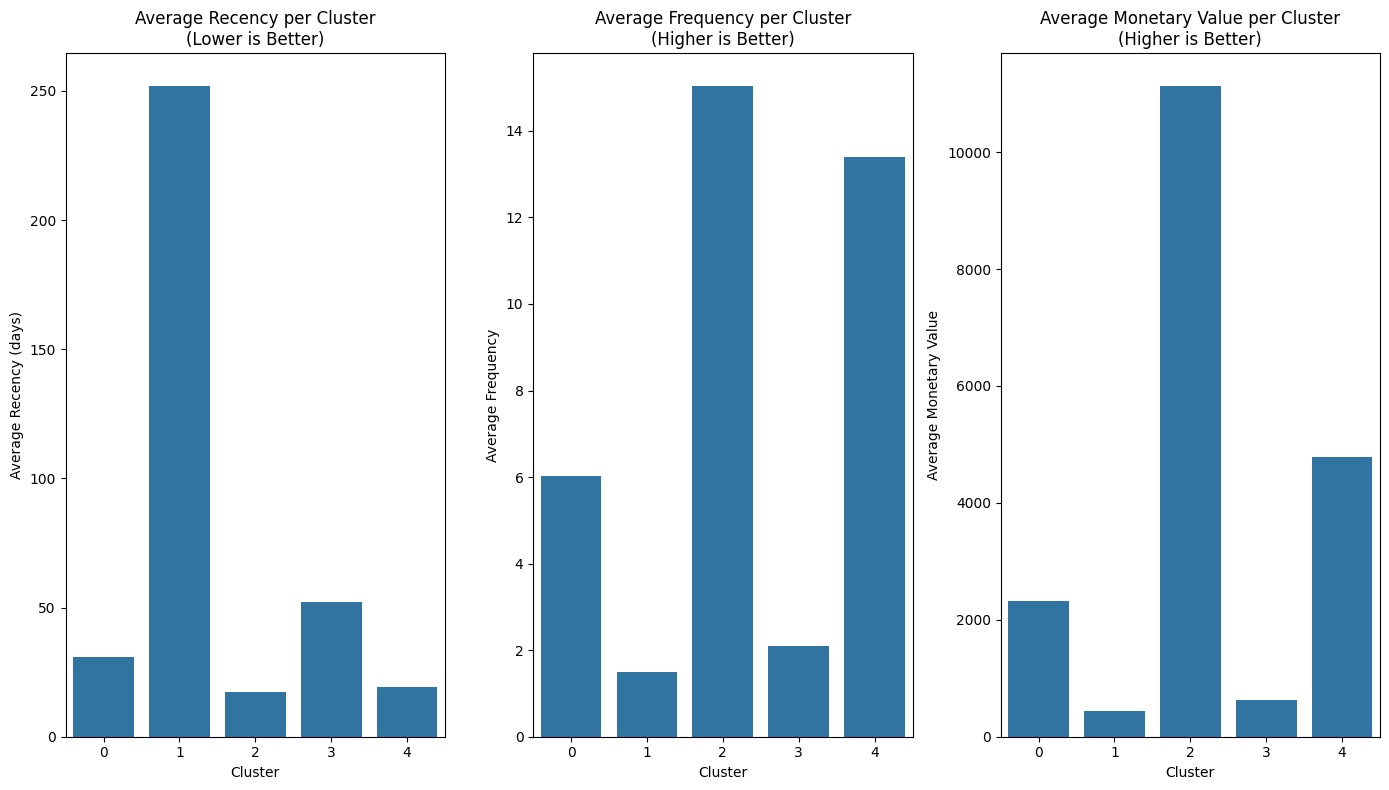

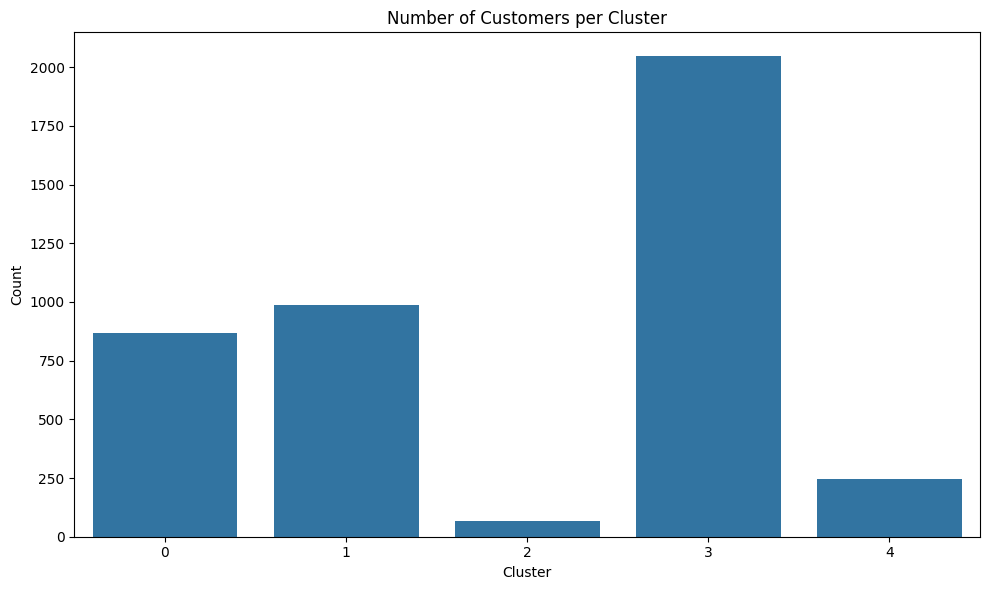

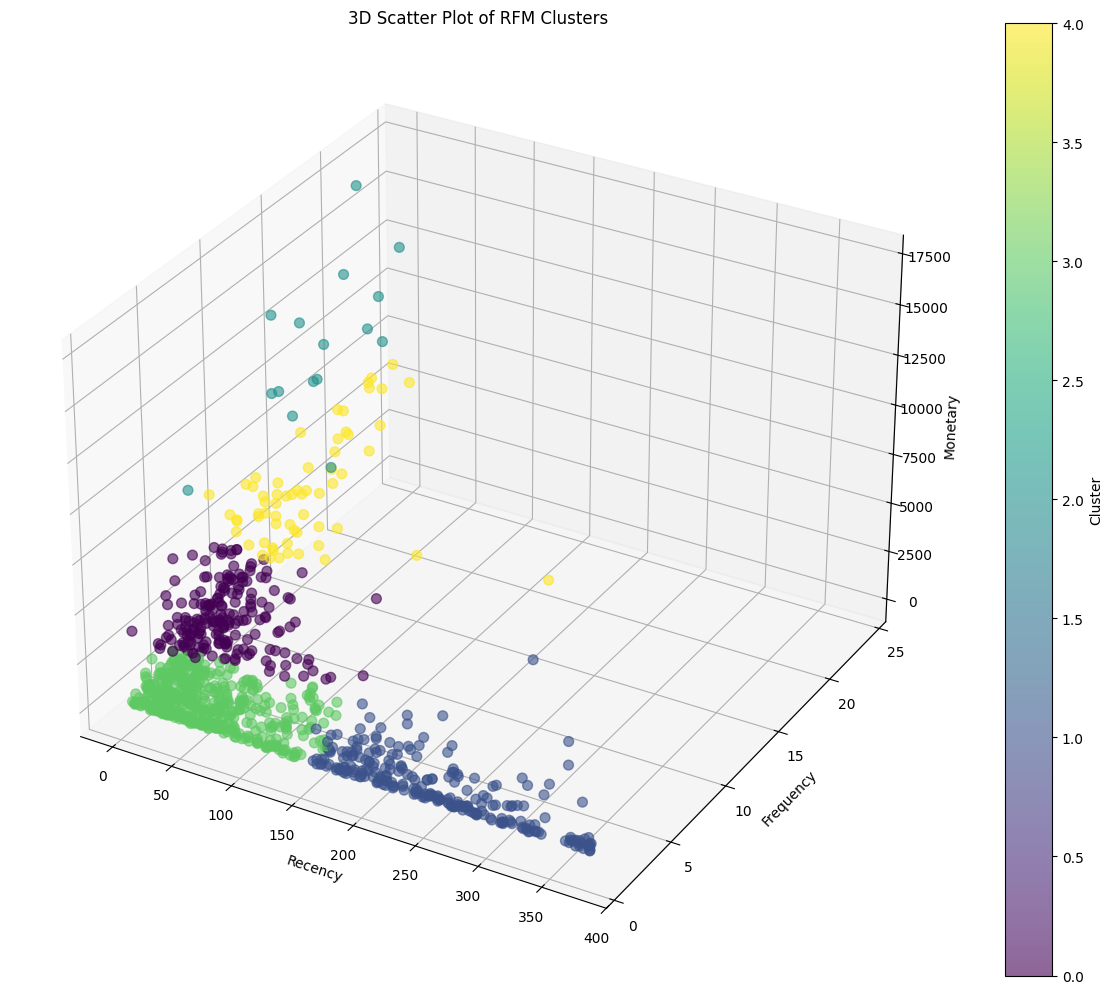

In [28]:

# 5. Interpretasi Hasil dan Profiling Cluster dengan Model Terbaik
print("\n\n5. INTERPRETASI HASIL DAN PROFILING CLUSTER")
print("="*50)

# Menggunakan model terbaik berdasarkan Silhouette Score
best_model_name = best_silhouette_model

print(f"\nAnalisis Cluster dari Model: {best_model_name}")

# Mendapatkan label cluster dari model terbaik
if 'K-Means' in best_model_name:
    best_labels = kmeans_labels
elif 'Agglomerative' in best_model_name:
    best_labels = agg_labels
elif 'DBSCAN' in best_model_name:
    best_labels = dbscan_labels
elif 'GMM' in best_model_name:
    best_labels = gmm_labels
elif 'Spectral' in best_model_name:
    best_labels = spectral_labels

# Menambahkan cluster ke data RFM
rfm_df['Cluster'] = best_labels

# Analisis karakteristik setiap cluster
cluster_analysis = rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'})

print("\nKarakteristik setiap cluster:")
print(cluster_analysis)

# Visualisasi karakteristik cluster
plt.figure(figsize=(14, 8))

# Recency per cluster (lower is better)
plt.subplot(1, 3, 1)
sns.barplot(x=cluster_analysis.index, y='Recency', data=cluster_analysis.reset_index())
plt.title('Average Recency per Cluster\n(Lower is Better)')
plt.xlabel('Cluster')
plt.ylabel('Average Recency (days)')

# Frequency per cluster (higher is better)
plt.subplot(1, 3, 2)
sns.barplot(x=cluster_analysis.index, y='Frequency', data=cluster_analysis.reset_index())
plt.title('Average Frequency per Cluster\n(Higher is Better)')
plt.xlabel('Cluster')
plt.ylabel('Average Frequency')

# Monetary per cluster (higher is better)
plt.subplot(1, 3, 3)
sns.barplot(x=cluster_analysis.index, y='Monetary', data=cluster_analysis.reset_index())
plt.title('Average Monetary Value per Cluster\n(Higher is Better)')
plt.xlabel('Cluster')
plt.ylabel('Average Monetary Value')

plt.tight_layout()
plt.show()

# Distribusi jumlah pelanggan per cluster
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_analysis.index, y='Count', data=cluster_analysis.reset_index())
plt.title('Number of Customers per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Visualisasi 3D Scatter plot untuk melihat posisi cluster di ruang RFM
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Sample data jika terlalu banyak poin
sample_indices = np.random.choice(len(rfm_df), size=min(1000, len(rfm_df)), replace=False)
sample_df = rfm_df.iloc[sample_indices]

scatter = ax.scatter(
    sample_df['Recency'],
    sample_df['Frequency'],
    sample_df['Monetary'],
    c=sample_df['Cluster'],
    cmap='viridis',
    s=50,
    alpha=0.6
)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D Scatter Plot of RFM Clusters')

plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()




6. KESIMPULAN DAN INTERPRETASI BISNIS

Berdasarkan analisis clustering menggunakan K-Means (k=5), pelanggan dapat dibagi menjadi 5 segmen berbeda.

Profil Cluster dengan Label:
            Recency  Frequency      Monetary  Count  RFM_Score  \
Cluster                                                          
0         30.923875   6.017301   2325.645467    867   0.495361   
1        251.987854   1.490891    443.471671    988   0.046308   
2         17.304348  15.043478  11137.639130     69   0.977110   
3         52.249267   2.092864    621.217416   2046   0.329183   
4         19.273469  13.387755   4791.951673    245   0.747900   

                     Label  
Cluster                     
0        Average Customers  
1           Lost Customers  
2                Champions  
3            New Customers  
4        Average Customers  


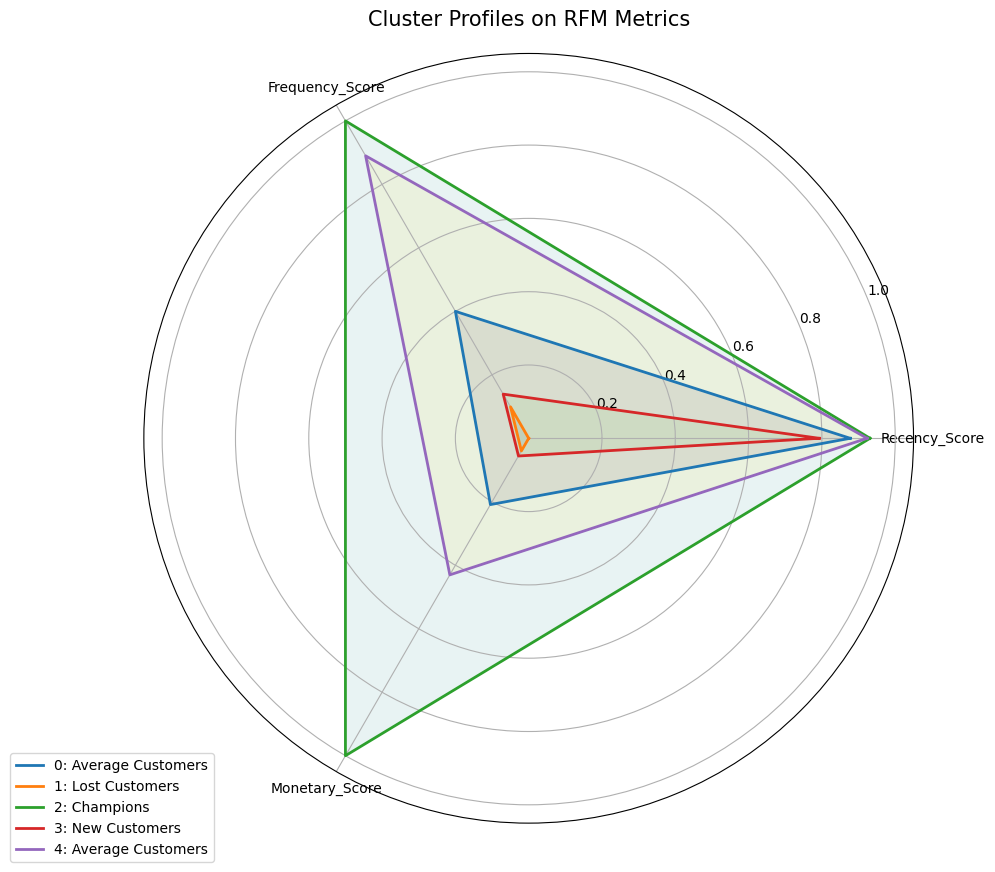


Ringkasan Strategi Bisnis berdasarkan Segmentasi Pelanggan:
----------------------------------------------------------------------

Cluster 0 - Average Customers (867 pelanggan, 20.57%):
  Recency: 30.92 hari | Frequency: 6.02 transaksi | Monetary: $2325.65
  Strategi: Tingkatkan engagement dengan konten relevan dan personalisasi.
  Berikan insentif untuk meningkatkan frekuensi dan nilai pembelian.

Cluster 1 - Lost Customers (988 pelanggan, 23.44%):
  Recency: 251.99 hari | Frequency: 1.49 transaksi | Monetary: $443.47
  Strategi: Reactivation campaign dengan penawaran khusus/diskon besar.
  Penting untuk mengidentifikasi alasan kehilangan pelanggan ini.

Cluster 2 - Champions (69 pelanggan, 1.64%):
  Recency: 17.3 hari | Frequency: 15.04 transaksi | Monetary: $11137.64
  Strategi: Pertahankan loyalitas. Tawarkan program membership dan rewards.
  Pelanggan ini adalah aset penting. Buat mereka merasa istimewa.

Cluster 3 - New Customers (2046 pelanggan, 48.54%):
  Recency: 52.25 hari 

In [29]:

# 6. Kesimpulan dan Interpretasi Bisnis
print("\n\n6. KESIMPULAN DAN INTERPRETASI BISNIS")
print("="*50)

print(f"\nBerdasarkan analisis clustering menggunakan {best_model_name}, pelanggan dapat dibagi menjadi {len(cluster_analysis)} segmen berbeda.")

# Memberikan nama untuk setiap cluster berdasarkan karakteristiknya
# Persiapkan data untuk normalisasi karakteristik
cluster_profiles = cluster_analysis.copy()
# Normalisasi agar mudah dibandingkan
cluster_profiles['Recency_Score'] = 1 - (cluster_profiles['Recency'] / cluster_profiles['Recency'].max())  # Lower is better, so invert
cluster_profiles['Frequency_Score'] = cluster_profiles['Frequency'] / cluster_profiles['Frequency'].max()
cluster_profiles['Monetary_Score'] = cluster_profiles['Monetary'] / cluster_profiles['Monetary'].max()
# Lanjutan dari kode sebelumnya
cluster_profiles['RFM_Score'] = (cluster_profiles['Recency_Score'] +
                                cluster_profiles['Frequency_Score'] +
                                cluster_profiles['Monetary_Score']) / 3

# Memberi label pada cluster berdasarkan karakteristik RFM
cluster_labels = {}
for cluster in cluster_profiles.index:
    r_score = cluster_profiles.loc[cluster, 'Recency_Score']
    f_score = cluster_profiles.loc[cluster, 'Frequency_Score']
    m_score = cluster_profiles.loc[cluster, 'Monetary_Score']
    overall = cluster_profiles.loc[cluster, 'RFM_Score']

    # Menentukan label berdasarkan kombinasi skor
    if overall > 0.75:
        cluster_labels[cluster] = "Champions"
    elif r_score > 0.7 and f_score > 0.5 and m_score > 0.5:
        cluster_labels[cluster] = "Loyal Customers"
    elif r_score > 0.6 and f_score < 0.3 and m_score > 0.5:
        cluster_labels[cluster] = "Potential Loyalists"
    elif r_score < 0.3 and f_score > 0.5 and m_score > 0.5:
        cluster_labels[cluster] = "At Risk Customers"
    elif r_score < 0.3 and f_score < 0.3 and m_score < 0.3:
        cluster_labels[cluster] = "Lost Customers"
    elif r_score > 0.7 and f_score < 0.3 and m_score < 0.3:
        cluster_labels[cluster] = "New Customers"
    elif r_score < 0.3 and f_score > 0.5 and m_score < 0.3:
        cluster_labels[cluster] = "Need Attention"
    else:
        cluster_labels[cluster] = "Average Customers"

# Menambahkan label ke dataframe analisis cluster
cluster_profiles['Label'] = pd.Series(cluster_labels)

print("\nProfil Cluster dengan Label:")
print(cluster_profiles[['Recency', 'Frequency', 'Monetary', 'Count', 'RFM_Score', 'Label']])

# Visualisasi RFM Score pada radar chart
def radar_chart(df, cluster_col, metrics):
    from math import pi

    # Jumlah variabel
    categories = metrics
    N = len(categories)

    # Mendapatkan nilai untuk setiap cluster
    clusters = df.index.tolist()

    # Membuat sudut untuk plot
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # Menutup plot

    # Inisialisasi plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    # Warna untuk setiap cluster
    colors = plt.cm.viridis(np.linspace(0, 1, len(clusters)))

    # Plot untuk setiap cluster
    for i, cluster in enumerate(clusters):
        values = df.loc[cluster, metrics].values.tolist()
        values += values[:1]  # Menutup plot

        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"{cluster}: {df.loc[cluster, 'Label']}")
        ax.fill(angles, values, color=colors[i], alpha=0.1)

    # Mendefinisikan label
    plt.xticks(angles[:-1], categories)

    # Menambahkan label dan legend
    ax.set_title("Cluster Profiles on RFM Metrics", size=15, pad=20)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    plt.tight_layout()
    plt.show()

# Memanggil fungsi radar chart
radar_metrics = ['Recency_Score', 'Frequency_Score', 'Monetary_Score']
radar_chart(cluster_profiles, 'Label', radar_metrics)

# Ringkasan strategi bisnis berdasarkan segmentasi pelanggan
print("\nRingkasan Strategi Bisnis berdasarkan Segmentasi Pelanggan:")
print("-" * 70)

for cluster, label in cluster_labels.items():
    r = round(cluster_profiles.loc[cluster, 'Recency'], 2)
    f = round(cluster_profiles.loc[cluster, 'Frequency'], 2)
    m = round(cluster_profiles.loc[cluster, 'Monetary'], 2)
    count = int(cluster_profiles.loc[cluster, 'Count'])
    pct = round(count / cluster_profiles['Count'].sum() * 100, 2)

    print(f"\nCluster {cluster} - {label} ({count} pelanggan, {pct}%):")
    print(f"  Recency: {r} hari | Frequency: {f} transaksi | Monetary: ${m}")

    # Rekomendasi strategi berdasarkan label
    if label == "Champions":
        print("  Strategi: Pertahankan loyalitas. Tawarkan program membership dan rewards.")
        print("  Pelanggan ini adalah aset penting. Buat mereka merasa istimewa.")
    elif label == "Loyal Customers":
        print("  Strategi: Tingkatkan frekuensi pembelian dengan penawaran upselling/cross-selling.")
        print("  Tawarkan program loyalitas untuk mempertahankan mereka.")
    elif label == "Potential Loyalists":
        print("  Strategi: Kembangkan hubungan dengan komunikasi terpersonalisasi.")
        print("  Tawarkan diskon untuk meningkatkan frekuensi pembelian.")
    elif label == "At Risk Customers":
        print("  Strategi: Win-back campaign. Tawarkan produk yang sesuai dengan sejarah pembelian.")
        print("  Lakukan survei untuk mengetahui penyebab tidak berbelanja lagi.")
    elif label == "Lost Customers":
        print("  Strategi: Reactivation campaign dengan penawaran khusus/diskon besar.")
        print("  Penting untuk mengidentifikasi alasan kehilangan pelanggan ini.")
    elif label == "New Customers":
        print("  Strategi: Onboarding dan edukasi produk. Tawarkan first-time buyer discount.")
        print("  Tingkatkan pengalaman pelanggan untuk mempertahankan mereka.")
    elif label == "Need Attention":
        print("  Strategi: Personalisasi penawaran. Tingkatkan nilai transaksi dengan bundling.")
        print("  Mereka sering bertransaksi tapi dengan nilai kecil - targetkan upselling.")
    else:  # Average Customers
        print("  Strategi: Tingkatkan engagement dengan konten relevan dan personalisasi.")
        print("  Berikan insentif untuk meningkatkan frekuensi dan nilai pembelian.")


In [32]:
# 8. Kesimpulan Akhir tentang Model Terbaik
print("\n\n8. KESIMPULAN AKHIR")
print("="*50)

# Menentukan model terbaik secara keseluruhan berdasarkan semua metrik
results_df['Overall_Rank'] = (
    results_df['Silhouette Score'].rank(ascending=False) +
    results_df['Davies-Bouldin Index'].rank(ascending=True) +
    results_df['Calinski-Harabasz Score'].rank(ascending=False)
) / 3

best_overall_model = results_df.loc[results_df['Overall_Rank'].idxmin()]['Model']

print(f"\nBerdasarkan evaluasi keseluruhan, model terbaik adalah: {best_overall_model}, untuk penjelasan lebih lengkap ada di PDF")



8. KESIMPULAN AKHIR

Berdasarkan evaluasi keseluruhan, model terbaik adalah: K-Means (k=5), untuk penjelasan lebih lengkap ada di PDF
